In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from util.preprocessing import parse_num_of_people, extract_month, extract_facility, extract_ratio, extract_population, extract_cost, count_days, calc_damage_scale, extract_middle_class, str_to_median
import re
from dateutil import parser
import numpy as np

# 2. 기존 데이터만 가지고 공종을 대분류로 바꾸고 비사고 데이터의 피쳐들에 맞게 기존 데이터 피쳐를 수정하여 학습해보기

df = pd.read_csv('./data/data/output.csv')
df1 = pd.read_csv("./data/data/no_accident_data.csv", encoding="cp949")
#필요 없는 특성 제거
allColumns = df.columns
params = ['발생일시','공공/민간 구분', '기상상태', '시설물 종류', '사망자수(명)', '부상자수(명)', '공사비', '공사기간', '공정률', '작업자수', '설계안전성검토', '공종']

df = df.drop(allColumns.drop(params), axis=1)

df = df.dropna()
# print(df.head)

# 공종에서 대분류만 추출하는 함수
def extract_first_class(s):
    if(type(s) == float):
        return("없음")
    return s.split(' > ')[0]

df['공종'] = df['공종'].apply(extract_first_class)
# print(df['공종'])

# print(df1.columns)

#범주형 데이터를 수치형 데이터로 인코딩

df['사망자수(명)'] = df['사망자수(명)'].apply(parse_num_of_people)
df['부상자수(명)'] = df['부상자수(명)'].apply(parse_num_of_people)
df['발생일시'] = df['발생일시'].apply(extract_month)
df['시설물 종류'] = df['시설물 종류'].apply(extract_facility)
df['공사기간'] = df['공사기간'].apply(count_days)
df['공정률'] = df['공정률'].apply(str_to_median)
df['작업자수'] = df['작업자수'].apply(extract_population)
df['공사비'] = df['공사비'].apply(extract_cost)
df['피해규모'] = df.apply(calc_damage_scale, axis=1)

# 기상 상태 컬럼 분리
df[['날씨', '기온', '습도']] = df['기상상태'].str.extract('날씨 : (\S+)기온 : (\d+)℃습도 : (\d+)%')
df = df.drop(['기상상태'], axis=1)
df = df.dropna()

# 발생 일시에서 월만 뽑아오는 함수
def extract_month1(s):
    try:
        month = int(s.split('-')[1])
    except:
        month = None
    return month

# 문자열 데이터를 중앙값으로 변환하는 함수
def extract_cost1(data_str):
    # 정규식을 사용하여 문자열에서 금액 범위를 추출합니다.
    try:
        range_pattern = r'(\d+억초과 \d+억이하)'
        range_match = re.search(range_pattern, data_str)
        if range_match:
            # 금액 범위가 있는 경우
            # 금액 범위를 문자열에서 추출하여, 최소값과 최대값을 계산합니다.
            range_str = range_match.group(1)
            range_values = range_str.split(' ')
            min_value = int(range_values[0].replace('억초과', '')) * 100000000
            max_value = int(range_values[1].replace('억이하', '')) * 100000000

            # 최소값과 최대값을 더한 후 2로 나누어 중앙값을 계산합니다.
            median_value = (min_value + max_value) / 2.0
        else:
            median_value = None
    except:
        # 금액 범위가 없는 경우
        # 예외 처리를 하거나 None 값을 반환합니다.
        median_value = None

    # 중앙값을 반환합니다.
    return median_value
#비사고 데이터 피쳐 수정
df1['발생일시'] = df1['일자'].apply(extract_month1)
df1['공사기간'] = df1['총공사일수']
df1['공사비'] = df1['공사비'].apply(extract_cost1)
df1['공공/민간 구분'] = df1['발주자구분']
df1['작업자수'] = df1['보유기술자수 ']


#비사고 데이터 사고 데이터에 추가
df['사고여부'] = 1 #사고 데이터에 사고 여부 컬럼 추가
#사고 데이터에 나머지 피쳐 제거
df.drop(['날씨', '기온', '습도', '시설물 종류', '사망자수(명)', '부상자수(명)', '공정률', '설계안전성검토'], axis=1, inplace=True)
# df1 데이터프레임에서 필요한 컬럼 선택
df1_selected = df1[['발생일시', '공사기간', '공사비', '공공/민간 구분', '작업자수', '사고여부']]
#추가
df = pd.concat([df, df1_selected], axis=1)


# #print(df['공정률'].value_counts())
# # print(df.head)
# le = LabelEncoder()
# df['설계안전성검토'] = le.fit_transform(df['설계안전성검토'])

# # 시설물 종류 특성을 원-핫 인코딩

# ct = ColumnTransformer([
# ('onehot', OneHotEncoder(sparse=False), ['시설물 종류', '공공/민간 구분', '날씨', '공종'])], remainder='passthrough'
# )
# ct.fit(df)
# X = ct.transform(df)
# # 컬럼 이름 리스트 생성

# num_cols = df.columns.tolist()
# ohe = ct.named_transformers_['onehot']
# ohe_cols = ohe.get_feature_names_out(['시설물 종류', '공공/민간 구분', '날씨', '공종']).tolist()
# new_cols = ohe_cols + num_cols
# new_cols.remove('시설물 종류')
# new_cols.remove('공공/민간 구분')
# new_cols.remove('날씨')
# new_cols.remove('공종')
# # DataFrame으로 변환

# df = pd.DataFrame(X, columns=new_cols)

# df = df.astype('float64')

# df['습도'] = df['습도'].apply(lambda x: x/100)

# # --------------------정제 완료 ----------------------------

# X = df.drop(['사망자수(명)', '부상자수(명)', '피해규모'], axis=1)
# y = df[['피해규모']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(X_train.shape)
#print(X_test.shape)

c:\Users\82105\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\82105\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


MSE: 0.32796637525855743


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
c:\Users\82105\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82105\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82105\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82105\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82105\anaconda3\lib\site-packages\IPython\core\pylab

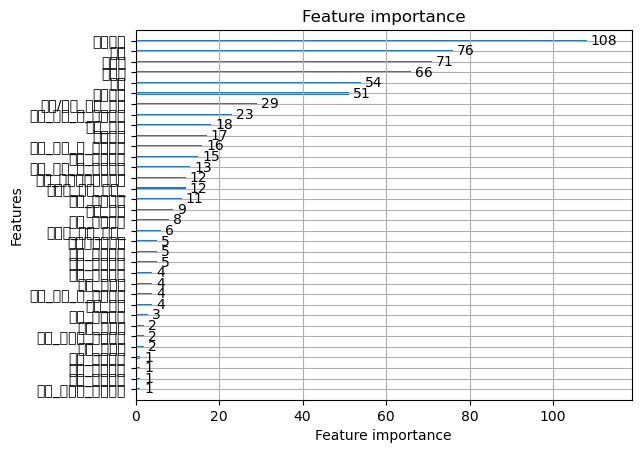

In [2]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import graphviz

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# LightGBM 모델 설정
params = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'], # 'set' 대신 'list'로 변경
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_weight': 0.1,
    'verbosity': -1
}

# 모델 학습
num_round = 100
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval], early_stopping_rounds=10, verbose_eval=0)

# 모델 예측
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# 예측값과 실제값의 MSE 계산
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

plt.rcParams['font.family'] = 'AppleGothic'

# 모델 feature importance 출력
lgb.plot_importance(bst)
plt.show()


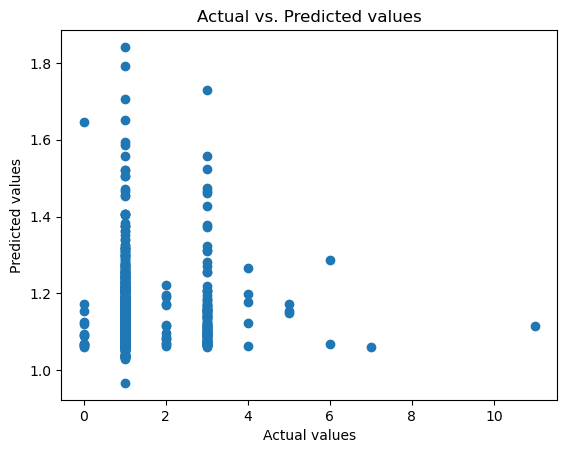

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font.
Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from current font.
Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from current font.
Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.

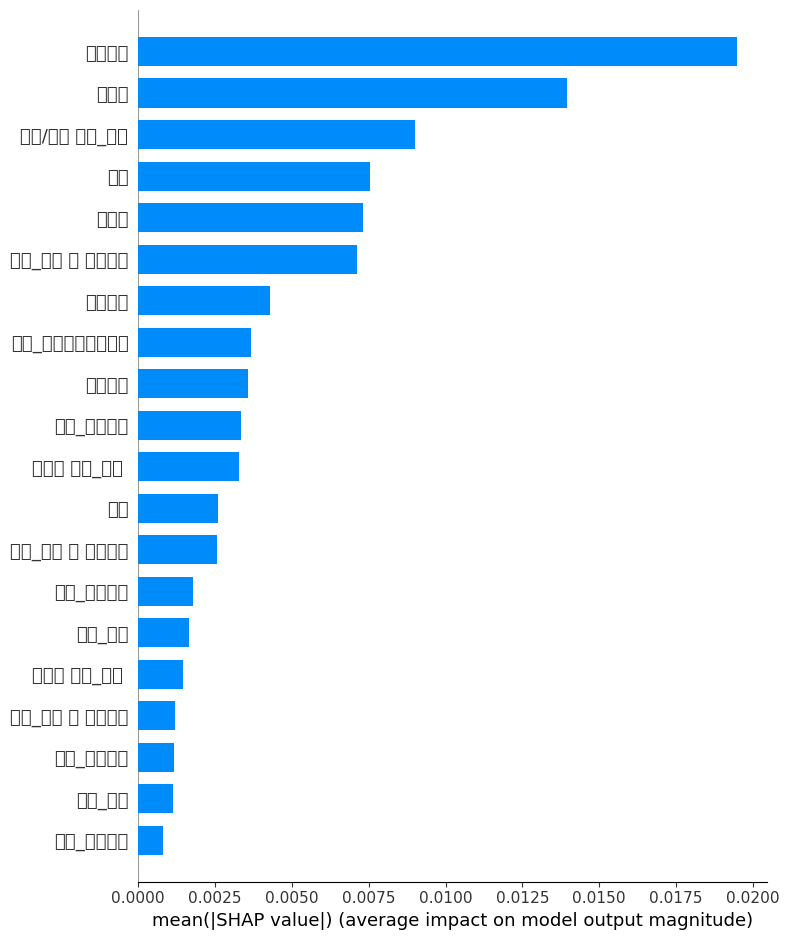

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [3]:
# 예측값과 실제값의 분포 확인
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted values')
plt.show()

# SHAP 값을 계산하여 feature importance와 함께 시각화
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# 모델의 예측값을 해석 가능한 형태로 변환하여 출력
import eli5

# 모델을 ELI5 형태로 변환
model_for_eli5 = lgb.LGBMRegressor(**params)
model_for_eli5.fit(X_train, y_train)

# feature importance와 함께 예측 결과 해석
eli5.show_prediction(model_for_eli5, X_test.iloc[0], feature_names=X_test.columns.tolist(), show_feature_values=True)
